In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt               

In [2]:
dataset = dgl.data.CSVDataset('../../Dati/Dataset_Binario/')
dataset

Done loading data from cached files.


Dataset("Dataset Binario", num_graphs=201, save_path=../../Dati/Dataset_Binario/Dataset Binario)

In [3]:
numer_class = []
a = 0
b = 0 
c = 0
d = 0
e = 0
f = 0
gg = 0
h = 0
for g, i in dataset:
    if i["label"].item() not in numer_class:
        numer_class.append(i["label"].item())
    if i["label"].item() == 0:
        a += 1
    elif i["label"].item() == 1:
        b += 1
    elif i["label"].item() == 2:
        c += 1
    elif i["label"].item() == 3:
        d += 1
    elif i["label"].item() == 4:
        e += 1
    elif i["label"].item() == 5:
        f += 1
    elif i["label"].item() == 6:
        gg += 1
    elif i["label"].item() == 7:
        h += 1

print(a, b, c, d, e, f, gg, h, (a+b+c+d+e+f+gg+h))
print(len(numer_class))

100 101 0 0 0 0 0 0 201
2


In [4]:
dim_nfeats = 2
gclasses = len(numer_class)

In [5]:
size_batch = len(numer_class)*2
size_batch

4

In [6]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size= size_batch, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size= size_batch, drop_last=False)

In [7]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=698, num_edges=22186,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), {'label': tensor([1., 0., 0., 1.])}]


In [8]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([219, 137, 123, 219])
Number of edges for each graph element in the batch: tensor([7072, 4308, 3770, 7036])
The original graphs in the minibatch:
[Graph(num_nodes=219, num_edges=7072,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=137, num_edges=4308,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=123, num_edges=3770,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=219, num_edges=7036,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})]


In [9]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [10]:
if gclasses == 2:
    num_of_epoches = 200
elif gclasses >= 2:
    num_of_epoches = 1000

In [11]:
# Create the model with given dimensions
loss_scores = {}
controllo = []
min_valore = 0.45

model = GCN(dim_nfeats, 256, gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



for epoch in range(num_of_epoches):
    print("Epoca: ", epoch)
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['label'].float())
        loss = F.cross_entropy(pred, labels['label'].long())
        #print("epoca: ", epoch, loss)
        optimizer.zero_grad()
        #print(optimizer)
        loss.backward()
        #print(loss)
        optimizer.step()
        #print(optimizer)
    print("   Loss -> ", loss.item())
    loss_scores[epoch] = loss.item()
    """if loss.item() < 0.4 and epoch >= 400:
        break"""
    if loss.item() < min_valore:
        controllo.append((epoch, loss.item()))
    

Epoca:  0


/Applications/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


   Loss ->  1.4398424625396729
Epoca:  1
   Loss ->  1.1049439907073975
Epoca:  2
   Loss ->  0.7044379711151123
Epoca:  3
   Loss ->  0.8054330348968506
Epoca:  4
   Loss ->  0.6670268177986145
Epoca:  5
   Loss ->  0.6570596694946289
Epoca:  6
   Loss ->  0.6950841546058655
Epoca:  7
   Loss ->  0.7714449167251587
Epoca:  8
   Loss ->  0.7224787473678589
Epoca:  9
   Loss ->  0.6621473431587219
Epoca:  10
   Loss ->  0.7365090847015381
Epoca:  11
   Loss ->  0.7022136449813843
Epoca:  12
   Loss ->  0.5864225029945374
Epoca:  13
   Loss ->  0.6444313526153564
Epoca:  14
   Loss ->  0.623665988445282
Epoca:  15
   Loss ->  0.6038442254066467
Epoca:  16
   Loss ->  0.6533294320106506
Epoca:  17
   Loss ->  0.5961723327636719
Epoca:  18
   Loss ->  0.5421801805496216
Epoca:  19
   Loss ->  0.5073764324188232
Epoca:  20
   Loss ->  0.6346473097801208
Epoca:  21
   Loss ->  0.47107556462287903
Epoca:  22
   Loss ->  0.6809278726577759
Epoca:  23
   Loss ->  0.5049564242362976
Epoca:  24
 

   Loss ->  1.0883500576019287
Epoca:  193
   Loss ->  0.6138258576393127
Epoca:  194
   Loss ->  0.40591961145401
Epoca:  195
   Loss ->  0.09740564227104187
Epoca:  196
   Loss ->  0.08130091428756714
Epoca:  197
   Loss ->  0.041304610669612885
Epoca:  198
   Loss ->  0.09422298520803452
Epoca:  199
   Loss ->  0.12467998266220093


In [12]:
print("Ultmia epoca ", epoch," con valore di loss ->", loss.item())

Ultmia epoca  199  con valore di loss -> 0.12467998266220093


In [13]:
for x in controllo:
    if x[1] < 0.45:
        print(x)

(28, 0.4345932602882385)
(32, 0.34877192974090576)
(34, 0.4402168393135071)
(36, 0.37139567732810974)
(40, 0.29860734939575195)
(41, 0.32397180795669556)
(43, 0.42374810576438904)
(44, 0.32728177309036255)
(46, 0.38930797576904297)
(47, 0.3413526713848114)
(48, 0.37798723578453064)
(49, 0.38480043411254883)
(50, 0.3192214071750641)
(51, 0.27176135778427124)
(53, 0.17655399441719055)
(58, 0.2438981831073761)
(59, 0.3827041685581207)
(60, 0.3147968649864197)
(62, 0.16346366703510284)
(65, 0.3231343626976013)
(66, 0.2534310817718506)
(67, 0.33038562536239624)
(68, 0.25096213817596436)
(70, 0.2023983746767044)
(71, 0.21894291043281555)
(72, 0.4459836184978485)
(73, 0.28710171580314636)
(75, 0.14814652502536774)
(76, 0.30194851756095886)
(77, 0.24375298619270325)
(79, 0.2762163579463959)
(83, 0.16648712754249573)
(84, 0.17047663033008575)
(86, 0.2130127102136612)
(87, 0.18196755647659302)
(89, 0.1805729866027832)
(90, 0.2662043273448944)
(91, 0.24970558285713196)
(92, 0.1057189404964447)
(9

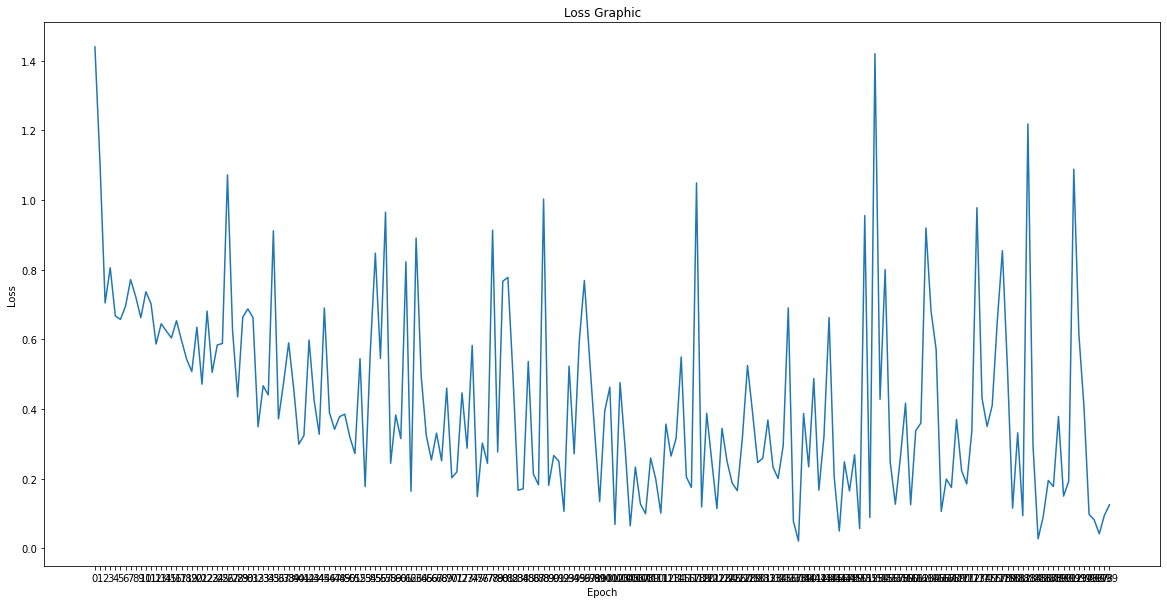

In [14]:
plt.figure(figsize = (20,10))
plt.plot(loss_scores.values())
plt.xticks(range(0,num_of_epoches,1), loss_scores.keys())
plt.title("Loss Graphic")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [15]:
num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['label'].float())
    num_correct += (pred.argmax(1) == labels['label'].long()).sum().item()
    num_tests += len(labels['label'].long())
    
    
print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.9024390243902439


## Analisi risultati
Con il dataset Binario l'accuratezza si aggira attorno al 0.9.
Con il dataset Multiplo il quale momentaneamente contiene 4 classi di grafi l'accuratezza si aggira attorno al 0.54.

## PROVE


Numero di nodi 16

batch = 10 epoche 1000 con soglia 400epoche e loss < 0.4 -> ***ACCURATEZZA OTTENUTA*** 0,61

batch = 8 epoche 5000  -> ***ACCURATEZZA OTTENUTA*** 0,61 con ultima loss -> 0.7

batch = 8 epoche 1000  -> ***ACCURATEZZA OTTENUTA*** 0,59 con ultima loss -> 0.87

batch = 8 epoche 1000  -> ***ACCURATEZZA OTTENUTA*** 0,63 con ultima loss -> 1.61





Numero di nodi 32

batch = 8 epoche 1000 ->  ***ACCURATEZZA OTTENUTA*** 0,62 con ultima loss ->  1.09


Numero di nodi 12

batch = 8 epoche 1000 ->  ***ACCURATEZZA OTTENUTA*** 0,62 con ultima loss ->   0.75







Numero di nodi 12 classificazione di sei classi 

batch = 12 epoche 1000 -> ***ACCURATEZZA OTTENUTA*** 0,42 con ultima loss ->  0.84